In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='0.8'
os.environ['XLA_FLAGS']='--xla_gpu_strict_conv_algorithm_picker=false'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from models import RecurModel
from utils.train import train_epoch, eval_model, train_step, create_train_state
from mazes_data import prepare_maze_loader, DataLoader

In [4]:
DATA_ROOT = "data"
datasets = prepare_maze_loader("data", 9, 33)
ds = datasets['train']

Files already downloaded and verified
Loading mazes of size 9 x 9.
Files already downloaded and verified
Loading mazes of size 33 x 33.


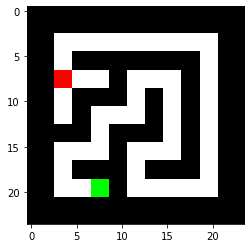

In [5]:
plt.imshow(ds[0][0].transpose(1, 2, 0))

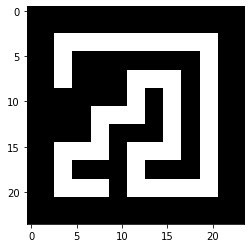

In [6]:
plt.imshow(ds[1][0], cmap='gray')

In [7]:
learning_rate = 0.001
momentum = 0.9

In [8]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [9]:
batch = (jax.random.normal(rng, shape=(40, 3, 24, 24)), jax.random.normal(rng, shape=(40, 24, 24)))

In [10]:
from utils.train import batched_predict

In [11]:
net = RecurModel(3, 128, key=jax.random.PRNGKey(0))

In [12]:
batched_predict_jit = jax.jit(batched_predict)

In [19]:
net_jit = jax.jit(net.proj)

In [20]:
%timeit net_jit(batch[0][0])

TypeError: unhashable type: 'DeviceArray'

In [15]:
%timeit train_step(state, batch)

ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification (None, None, 0) for value tree PyTreeDef((CustomNode(<class 'models.RecurModel'>[(('proj', 'iter_block', 'head'), (), ())], [CustomNode(<class 'equinox.nn.conv.Conv2d'>[(('weight', 'bias'), ('num_spatial_dims', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'use_bias'), (2, 3, 128, (3, 3), (1, 1), ((1, 1), (1, 1)), (1, 1), False))], [*, None]), CustomNode(<class 'equinox.nn.composed.Sequential'>[(('layers',), (), ())], [[CustomNode(<class 'models.BacisBlock2D'>[(('conv1', 'conv2'), (), ())], [CustomNode(<class 'equinox.nn.conv.Conv2d'>[(('weight', 'bias'), ('num_spatial_dims', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'use_bias'), (2, 128, 128, (3, 3), (1, 1), ((1, 1), (1, 1)), (1, 1), False))], [*, None]), CustomNode(<class 'equinox.nn.conv.Conv2d'>[(('weight', 'bias'), ('num_spatial_dims', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'use_bias'), (2, 128, 128, (3, 3), (1, 1), ((1, 1), (1, 1)), (1, 1), False))], [*, None])]), CustomNode(<class 'models.BacisBlock2D'>[(('conv1', 'conv2'), (), ())], [CustomNode(<class 'equinox.nn.conv.Conv2d'>[(('weight', 'bias'), ('num_spatial_dims', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'use_bias'), (2, 128, 128, (3, 3), (1, 1), ((1, 1), (1, 1)), (1, 1), False))], [*, None]), CustomNode(<class 'equinox.nn.conv.Conv2d'>[(('weight', 'bias'), ('num_spatial_dims', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'use_bias'), (2, 128, 128, (3, 3), (1, 1), ((1, 1), (1, 1)), (1, 1), False))], [*, None])])]]), [CustomNode(<class 'equinox.nn.conv.Conv2d'>[(('weight', 'bias'), ('num_spatial_dims', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'use_bias'), (2, 128, 32, (3, 3), (1, 1), ((1, 1), (1, 1)), (1, 1), False))], [*, None]), CustomNode(<class 'equinox.nn.conv.Conv2d'>[(('weight', 'bias'), ('num_spatial_dims', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'use_bias'), (2, 32, 8, (3, 3), (1, 1), ((1, 1), (1, 1)), (1, 1), False))], [*, None]), CustomNode(<class 'equinox.nn.conv.Conv2d'>[(('weight', 'bias'), ('num_spatial_dims', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'use_bias'), (2, 8, 2, (3, 3), (1, 1), ((1, 1), (1, 1)), (1, 1), False))], [*, None])]]), *)).

In [13]:
num_epochs = 150
batch_size = 40

In [14]:
import time

In [15]:
key = rng
dl = DataLoader(datasets['train'], batch_size)
for epoch in range(1, num_epochs + 1):
  # Run an optimization step over a training batch
  start_time = time.time()
  key, skey = jax.random.split(key)
  # perms = ds_perms(50, skey, datasets['train'])
  dl.new_perms(skey)
  state = train_epoch(state, dl, epoch)
  epoch_time = time.time() - start_time
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))

100%|██████████| 1000/1000 [05:29<00:00,  3.03it/s]


train epoch: 1, loss: 0.2074, accuracy: 0.00
Epoch 1 in 330.95 sec


  2%|▏         | 18/1000 [00:06<05:41,  2.87it/s]


KeyboardInterrupt: 

In [17]:
state.params

Sequential(
  layers=[
    BacisBlock2D(
      conv1=Conv2d(
        num_spatial_dims=2,
        weight=f32[128,128,3,3],
        bias=None,
        in_channels=128,
        out_channels=128,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding=((1, 1), (1, 1)),
        dilation=(1, 1),
        use_bias=False
      ),
      conv2=Conv2d(
        num_spatial_dims=2,
        weight=f32[128,128,3,3],
        bias=None,
        in_channels=128,
        out_channels=128,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding=((1, 1), (1, 1)),
        dilation=(1, 1),
        use_bias=False
      )
    ),
    BacisBlock2D(
      conv1=Conv2d(
        num_spatial_dims=2,
        weight=f32[128,128,3,3],
        bias=None,
        in_channels=128,
        out_channels=128,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding=((1, 1), (1, 1)),
        dilation=(1, 1),
        use_bias=False
      ),
      conv2=Conv2d(
        num_spatial_dims=2,
        

In [24]:
param_count = np.sum(x.size for x in jax.tree_leaves(state[0]))

/tmp/ipykernel_77244/2600573195.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  param_count = np.sum(x.size for x in jax.tree_leaves(state[0]))
